In [ ]:
# Import modules
from astropy.io import fits
from astropy.table import Table
import numpy as np
import os, os.path


#Building a list of all exposures subdivided by CCDs
path, dirsyear, files = next(os.walk(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51"))

night = []
ccdn = []

#Counting number of files in a directory and a list of all hd5 file names.  
#This will be used to create a blank array for mean offsets.
for i in dirsyear:
    path, dirsnight, files = next(os.walk(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\{0}".format(i)))
    for j in dirsnight:
        path, dirs, filesnight = next(os.walk(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\{0}\{1}\pcat".format(i,j)))
        for k in filesnight:
            ccd = [k + ", path='{0}'".format(l) for l in range(1,7)]
            night += ccd
            
#Split nights array
ccdn = [s[22] for s in night]
nights = [s[0:14] for s in night]
nights

#Build fits array
files = np.array(nights)
mean = np.zeros(len(nights))
unc = np.zeros(len(nights))
ra = np.zeros(len(nights))
dec = np.zeros(len(nights))
ccdn = np.array(ccdn)
col1 = fits.Column(name='night', format='A15', array=files)
col2 = fits.Column(name='ccdn', format='I', array=ccdn)
col3 = fits.Column(name='unc', format='D05', array=unc)
col4 = fits.Column(name='mean', format='D05', array=mean)
col5 = fits.Column(name='ra', format='D05', array=mean)
col6 = fits.Column(name='dec', format='D05', array=mean)
coldefs = fits.ColDefs([col1, col2,col3,col4,col5,col6])
moff = fits.BinTableHDU.from_columns(coldefs)
x = Table.read(moff)

#For loop to append mean offsets, uncertainties, and RA/DEC to array for each file
for i, v in enumerate(x['night']):
    #Loading data from night one
    z = Table.read(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}".format(v[1:3],v[0:7],v[0:14]), path="{0}".format(x['ccdn'][i]))

    #loading dwarf locus data
    dat = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\gaiad51_dwarflocus.fits')

    #Removing nans from Gaia BP and RP matched photometry
    ind = np.isnan(z['phot_bp_mean_mag'])
    tb = z['phot_bp_mean_mag']
    tr = z['phot_rp_mean_mag']
    dd = z['ddo51']
    ra = z['ra']
    dec = z['de']
    ind = np.where((~np.isnan(tb))&(~np.isnan(tr))&(~np.isnan(dd)))

    #Remove any row with a nan in BP or RP
    tb = tb[ind]
    tr = tr[ind]
    dd = dd[ind]
    ra = ra[ind]
    dec = dec[ind]
    
    #Zero-point data
    #Calculate differences between photometric bands
    bprp = tb-tr
    bpd = tb-dd
    dt = np.dtype([('bprp',float),('bpd',float)])
    zerop = np.zeros(len(dd), dtype=dt)
    zerop['bprp'] = bprp
    zerop['bpd'] = bpd
    
    #Focus on values near the dwarf locus
    ind = np.where((zerop['bprp']<3)&(zerop['bpd']<3))
    zerop = zerop[ind]
    hist, xedges, yedges = np.histogram2d(zerop['bprp'],zerop['bpd'], [50,50])
    ind = np.where(hist == hist.max())
    
    #Find the location of highest density in the locus
    x0 = xedges[ind[0]][0]
    y0 = yedges[ind[1]][0]
    good = np.where((zerop['bpd']<(y0+0.15))&(zerop['bpd']>(y0-0.68))&(zerop['bprp']<(x0+2.17))&(zerop['bprp']>(x0-0.574)))
    zerop = zerop[good]
    
    #Calculate mean offset for field and append to fits table moff
    photint = np.interp(zerop['bprp'],dat['BPRP'],dat['BPD'])
    diff = zerop['bpd']  - photint

    #Adding means to mean column
    m = np.mean(diff)
    loc = np.where(moff.data['night']==v)
    moff.data['mean'][loc] = m
    
    #Adding uncertainty
    moff.data['unc'][loc] = np.std(diff)/np.sqrt(len(diff))
    
    #Adding RA and DEC
    moff.data['ra'][loc] = np.median(ra)
    moff.data['dec'][loc] = np.median(dec)
    
#Save array
np.save(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\muoffsets.npy',moff.data)

<IPython.core.display.Javascript object>


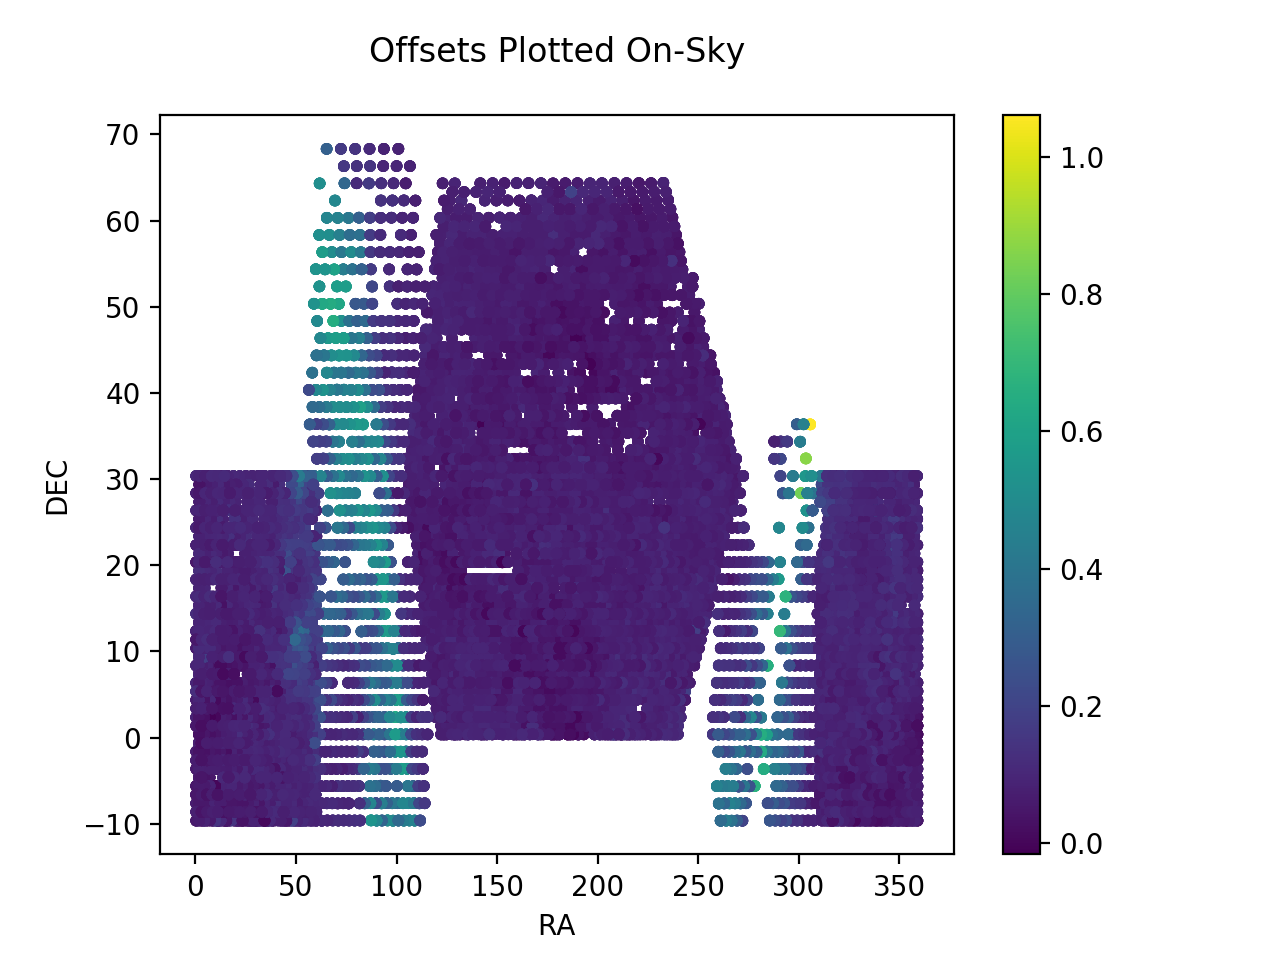

In [21]:
#Import modules
import matplotlib.pyplot as plt
%matplotlib nbagg

#Load as fits table
z = Table.read(moff)

#Cut out outliers
ind = np.where(z['mean']>-3)
z = z[ind]

#Reassign variables
x = z['ra']
y = z['dec']
c = z['mean']

#Create plot
plt.scatter(x,y,c=c,s=10)
cbar = plt.colorbar()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Offsets Plotted On-Sky', y=1.05)

plt.show()

<IPython.core.display.Javascript object>


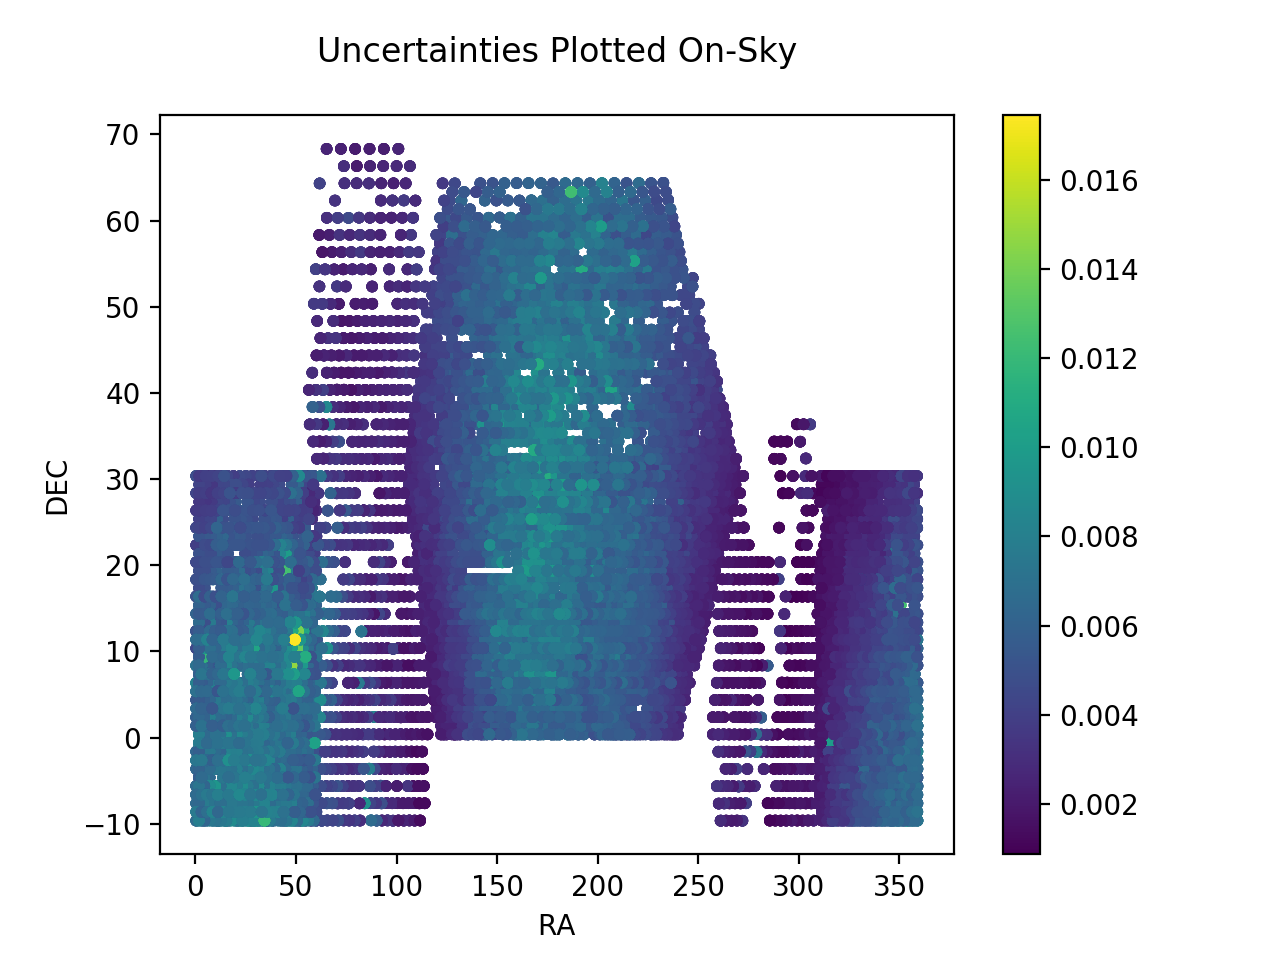

In [22]:
#Import modules
import matplotlib.pyplot as plt
%matplotlib nbagg

#Load as fits table
z = Table.read(moff)

#Cut out outliers
ind = np.where(z['mean']>-3)
z = z[ind]

#Reassign variables
x = z['ra']
y = z['dec']
c = z['unc']

#Create plot
plt.scatter(x,y,c=c,s=10)
cbar = plt.colorbar()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Uncertainties Plotted On-Sky', y=1.05)

plt.show()

<IPython.core.display.Javascript object>


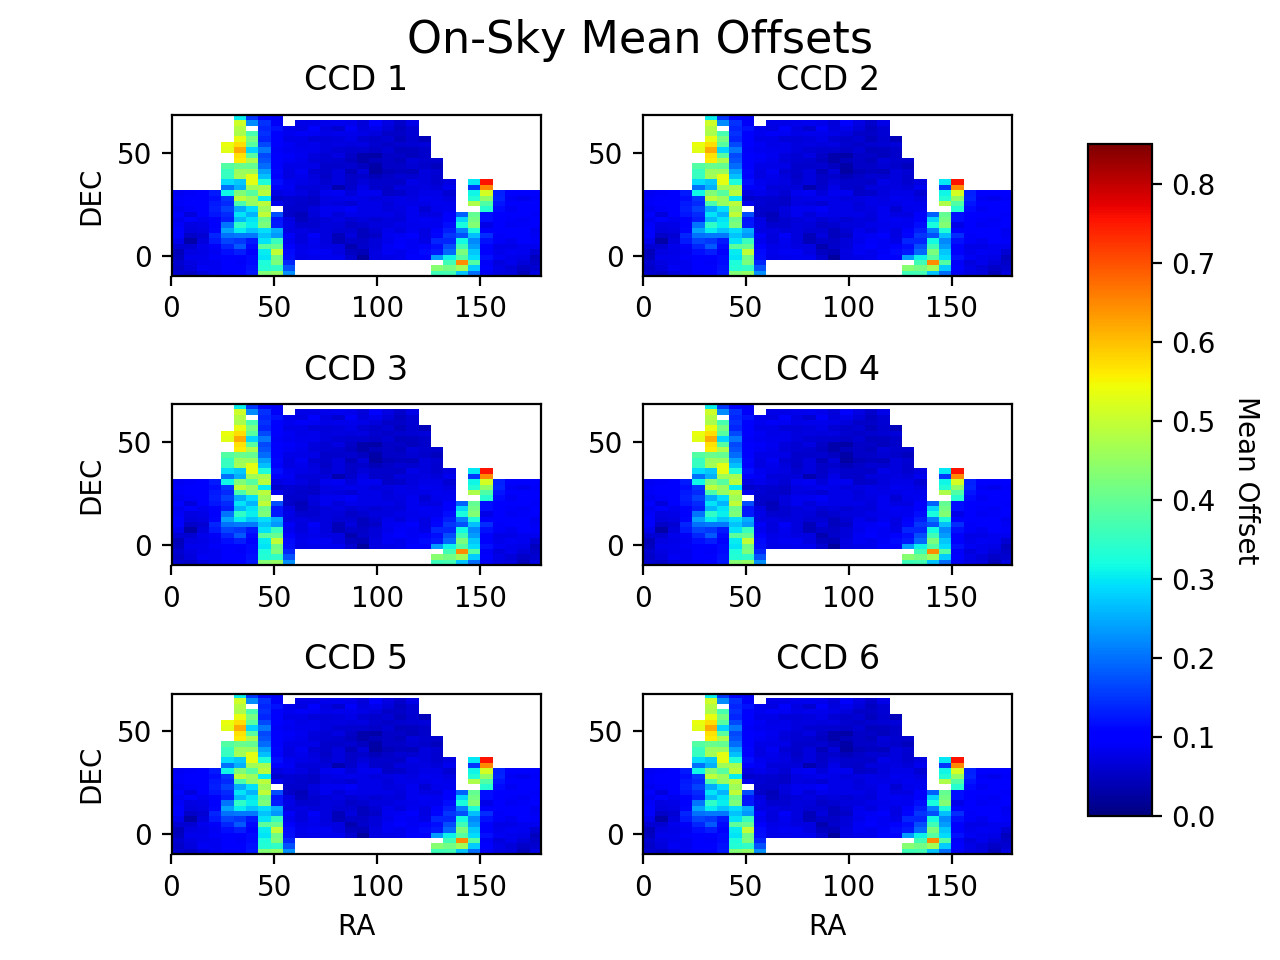

In [138]:
###OFFSETS
#Import modules
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib nbagg

#Load data as fits table
z = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\muoffsets.npy')

#Cut out outliers
ind = np.where(z['mean']>-3)
z = z[ind]

#Reassign variables
x = z['ra']
y = z['dec']
c = z['mean']

fig, axes = plt.subplots(nrows=3, ncols=2)

#CCD 1
ind = np.where(z['ccdn']==1)
plt.subplot(3, 2, 1)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.85)
plt.ylabel('DEC')
plt.title('CCD 1', y=1.05)

#CCD 2
ind = np.where(z['ccdn']==2)
plt.subplot(3, 2, 2)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.85)
#plt.ylabel('DEC')
plt.title('CCD 2', y=1.05)

#CCD 3
ind = np.where(z['ccdn']==3)
plt.subplot(3, 2, 3)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.85)
plt.ylabel('DEC')
plt.title('CCD 3', y=1.05)

#CCD 4
ind = np.where(z['ccdn']==4)
plt.subplot(3, 2, 4)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.85)
#plt.ylabel('DEC')
plt.title('CCD 4', y=1.05)

#CCD 5
ind = np.where(z['ccdn']==5)
plt.subplot(3, 2, 5)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.85)
plt.ylabel('DEC')
plt.xlabel('RA')
plt.title('CCD 5', y=1.05)

#CCD 6
ind = np.where(z['ccdn']==6)
plt.subplot(3, 2, 6)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.85)
#plt.ylabel('DEC')
plt.xlabel('RA')
plt.title('CCD 6', y=1.05)

#Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax, cax=cbar_ax)
cbar_ax.set_ylabel('Mean Offset', rotation=270, labelpad=+16)

fig.suptitle('On-Sky DDO51 Mean Offsets', fontsize=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.8)
plt.show()

<IPython.core.display.Javascript object>


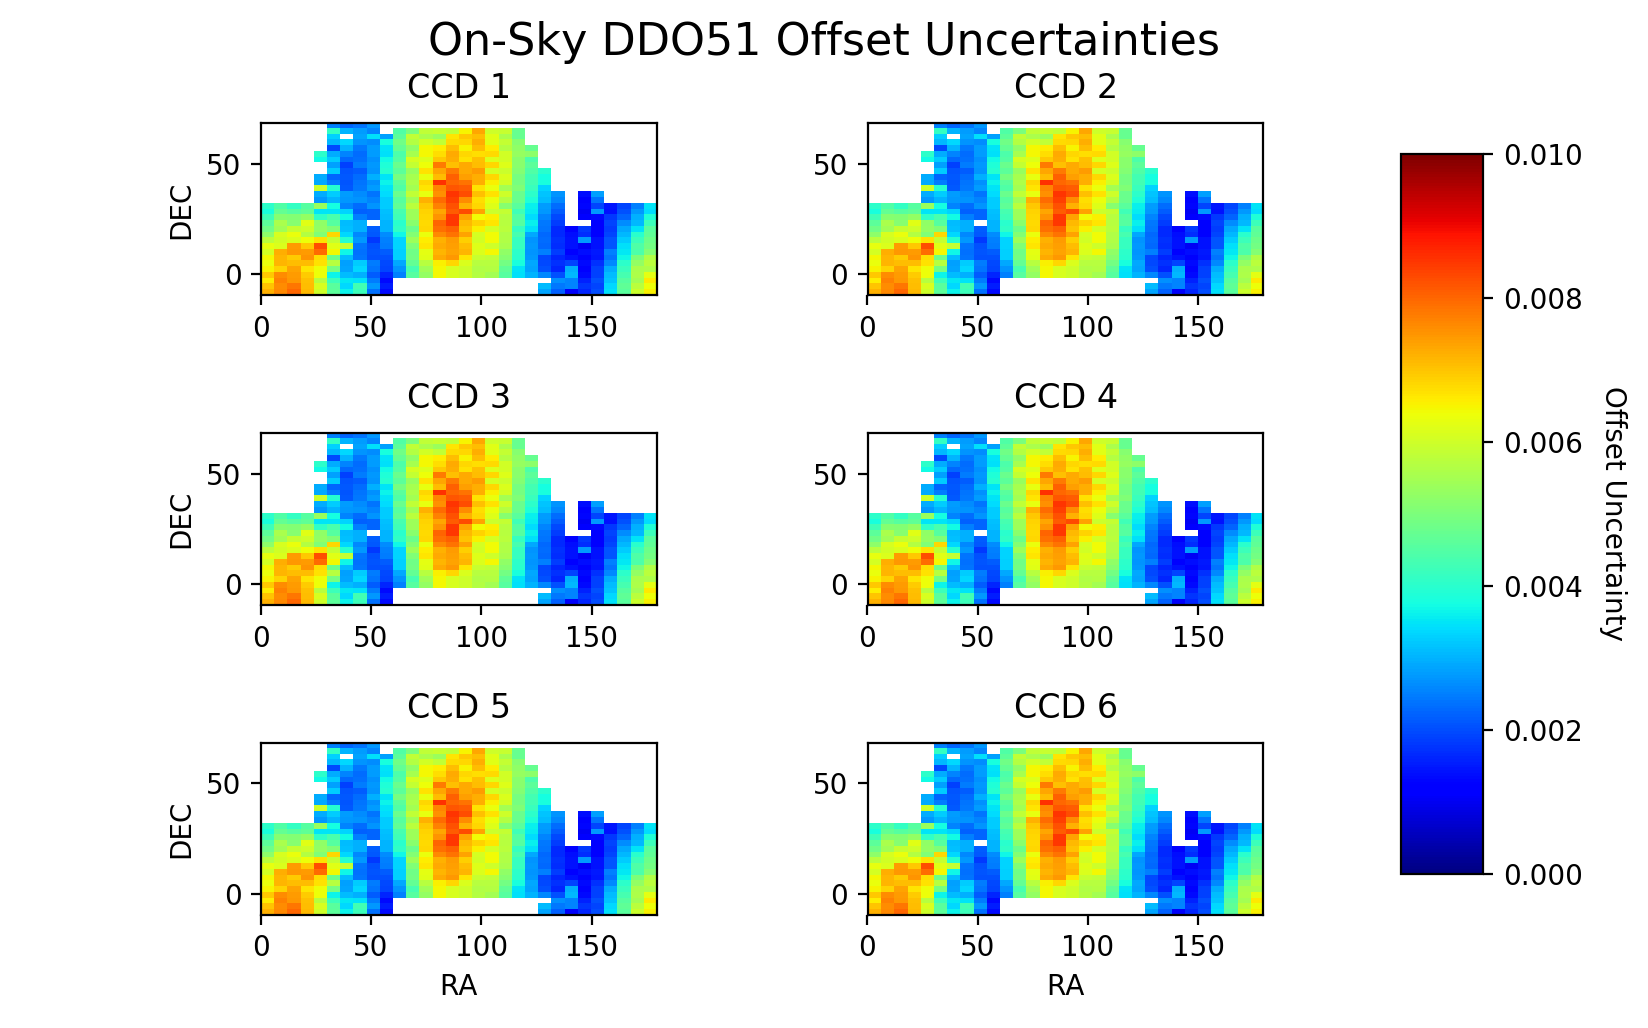

In [145]:
###UNCERTAINTIES
#Import modules
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib nbagg

#Load data as fits table
z = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\muoffsets.npy')

#Cut out outliers
ind = np.where(z['mean']>-3)
z = z[ind]

#Reassign variables
x = z['ra']
y = z['dec']
c = z['unc']

fig, axes = plt.subplots(nrows=3, ncols=2)

#CCD 1
ind = np.where(z['ccdn']==1)
plt.subplot(3, 2, 1)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.01)
plt.ylabel('DEC')
plt.title('CCD 1', y=1.05)

#CCD 2
ind = np.where(z['ccdn']==2)
plt.subplot(3, 2, 2)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.01)
#plt.ylabel('DEC')
plt.title('CCD 2', y=1.05)

#CCD 3
ind = np.where(z['ccdn']==3)
plt.subplot(3, 2, 3)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.01)
plt.ylabel('DEC')
plt.title('CCD 3', y=1.05)

#CCD 4
ind = np.where(z['ccdn']==4)
plt.subplot(3, 2, 4)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.01)
#plt.ylabel('DEC')
plt.title('CCD 4', y=1.05)

#CCD 5
ind = np.where(z['ccdn']==5)
plt.subplot(3, 2, 5)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.01)
plt.ylabel('DEC')
plt.xlabel('RA')
plt.title('CCD 5', y=1.05)

#CCD 6
ind = np.where(z['ccdn']==6)
plt.subplot(3, 2, 6)
ret,xedge,yedge,bin = stats.binned_statistic_2d(x[ind],y[ind],c[ind],'median',30)
ax = plt.imshow(ret.T,extent=[xedge.min()/2,xedge.max()/2,yedge.min(),yedge.max()],origin='lower',cmap='jet',vmin=0, vmax=0.01)
#plt.ylabel('DEC')
plt.xlabel('RA')
plt.title('CCD 6', y=1.05)

#Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax, cax=cbar_ax)
cbar_ax.set_ylabel('Offset Uncertainty', rotation=270, labelpad=+16)

fig.suptitle('On-Sky DDO51 Offset Uncertainties', fontsize=16)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.8)
plt.show()